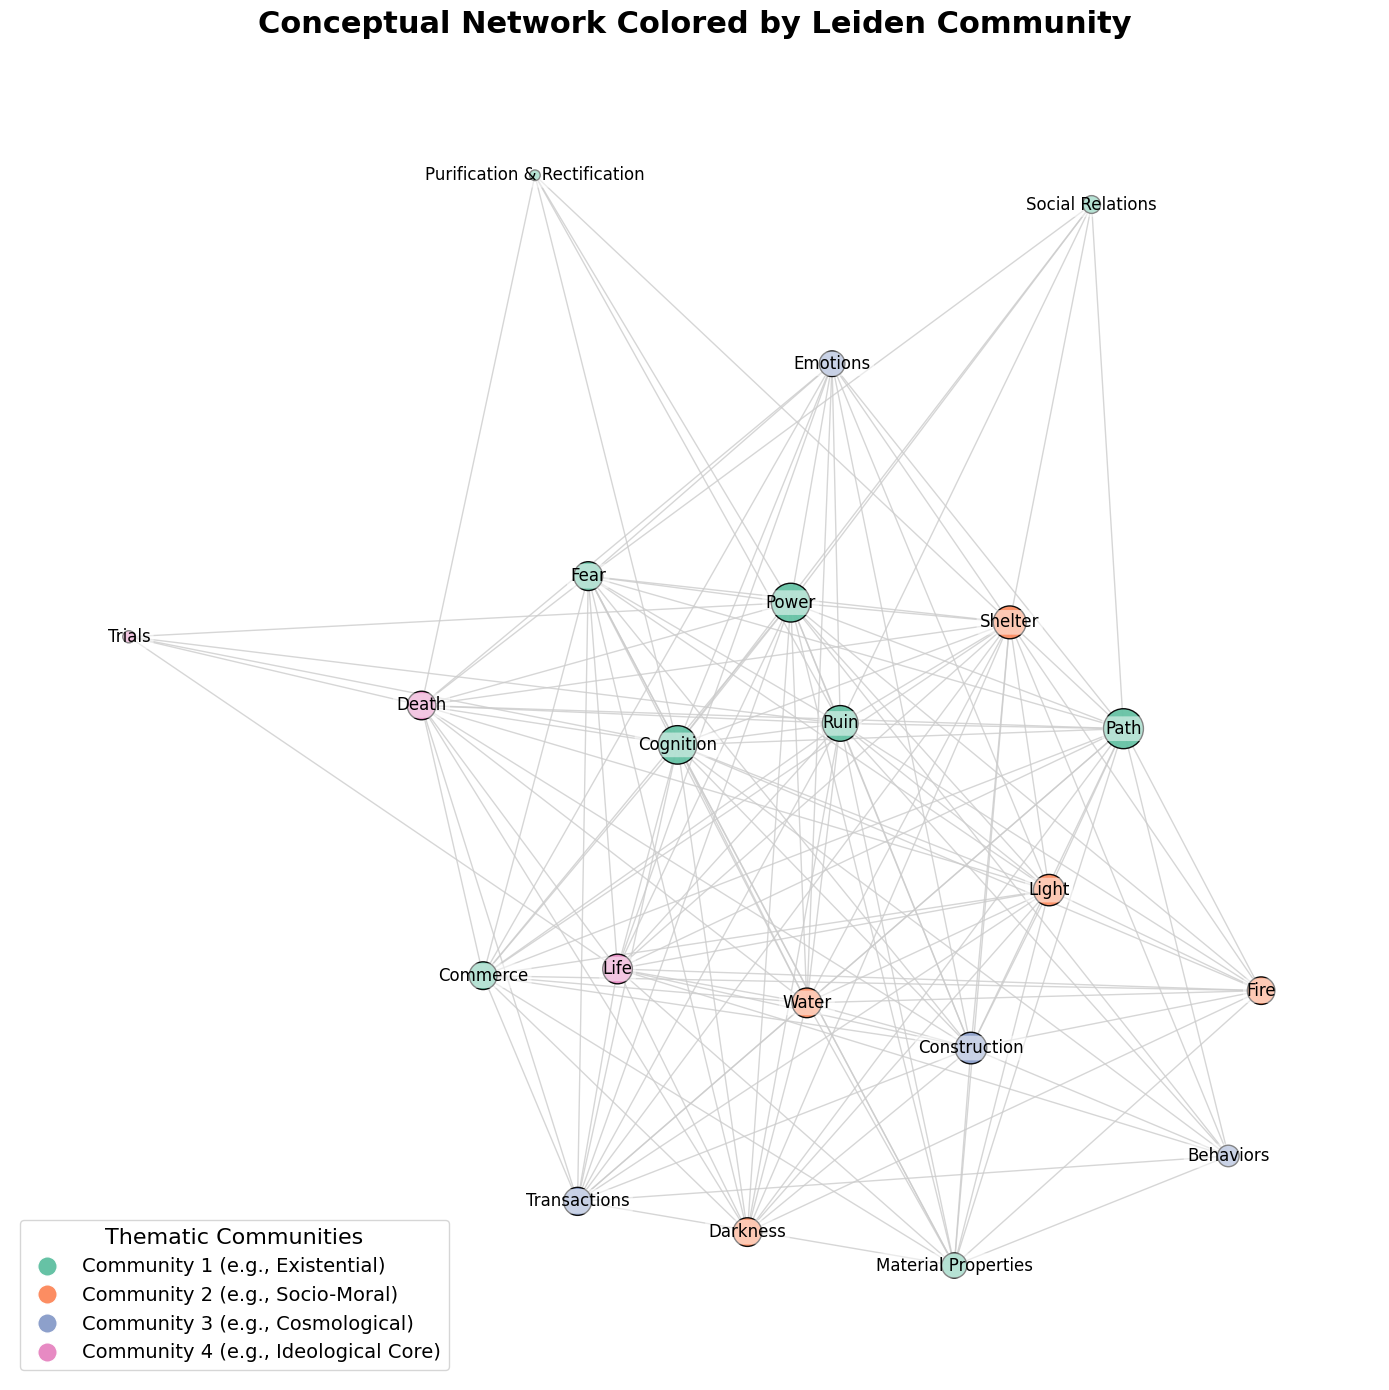


✅ Figure saved successfully: Figure_4a_Revised_Leiden.png


In [1]:
# ==============================================================================
# ✅ Global Network Visualization Colored by Leiden Communities
# ==============================================================================
#@title  **Global Network Visualization Colored by Leiden Communities**

# --- [الخطوة 0: تثبيت المكتبات] ---
# We need leidenalg and python-igraph now, instead of python-louvain
print("--- [Step 0: Installing Libraries] ---")
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config
!pip install -qq pygraphviz seaborn matplotlib networkx pandas numpy python-igraph leidenalg
print("Libraries installed successfully.\n")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


# --- [الخطوة 1: الاستيراد] ---
print("--- [Step 1: Importing Libraries] ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
import warnings
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout
#  ✅  تغيير: استيراد المكتبات الجديدة
import igraph as ig
import leidenalg as la
import ast

# تجاهل التحذيرات غير الضرورية
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Libraries imported successfully.\n")


# --- [الخطوة 2: تحميل وتجهيز البيانات] ---
print("--- [Step 2: Loading and Preparing Data] ---")
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()


# --- [الخطوة 3: بناء الشبكة (بالطريقة الدقيقة) وتشغيل خوارزمية Leiden] ---
print("--- [Step 3: Building Network (Accurate Weighting) and Detecting Communities with Leiden] ---")
#  ✅  تغيير: استخدام طريقة الوزن الدقيقة
G = nx.Graph()
verses = df.groupby(['Sura_No', 'Aya_No'])

for name, group in verses:
    concepts_in_verse = list(set(group['Dominant_Concept']))
    if len(concepts_in_verse) > 1:
        verse_text = group['vers_text'].iloc[0]
        verse_length = len(str(verse_text).split())
        weight = 1 / verse_length if verse_length > 0 else 0

        for concept1, concept2 in combinations(concepts_in_verse, 2):
            if G.has_edge(concept1, concept2):
                G[concept1][concept2]['weight'] += weight
            else:
                G.add_edge(concept1, concept2, weight=weight)

#  ✅  تغيير: تشغيل خوارزمية Leiden
G_ig = ig.Graph.from_networkx(G)
# استخدام seed ثابت للحصول على نفس النتيجة في كل مرة نشغل الكود للرسم
partition_leiden = la.find_partition(G_ig, la.RBConfigurationVertexPartition, weights='weight', seed=42)
num_communities = len(partition_leiden)

# تحويل نتيجة Leiden إلى الصيغة التي يفهمها NetworkX
partition = {}
for i, community in enumerate(partition_leiden):
    for vertex_index in community:
        node_name = G_ig.vs[vertex_index]['_nx_name']
        partition[node_name] = i

nx.set_node_attributes(G, partition, 'community')
print(f"✅ Found {num_communities} communities using Leiden algorithm.\n")


# --- [الخطوة التحليلية: طباعة النتائج الدقيقة] ---
print("--- [START] ACCURATE ANALYTICAL OUTPUT FOR REWRITING SECTION 4.3 ---")

# (1) حساب درجة المعيارية (Modularity Score)
modularity = partition_leiden.modularity
print(f"\n--- [1] Modularity Score ---")
print(f"The modularity of the Leiden partition is: {modularity:.4f}")

# (2) قائمة المفاهيم في كل مجتمع
communities_dict = {}
for node, comm_id in partition.items():
    if comm_id not in communities_dict:
        communities_dict[comm_id] = []
    communities_dict[comm_id].append(node)

print("\n--- [2] Concepts per Community ---")
for comm_id, nodes in sorted(communities_dict.items()):
    print(f"Community {comm_id}: {sorted(nodes)}")

# (3) أهم المفاهيم في كل مجتمع
# ... (بقية الكود التحليلي والرسم يبقى كما هو)
print("\n--- [3] Most Central Concepts within Each Community ---")
for comm_id in sorted(communities_dict.keys()):
    subgraph_nodes = communities_dict[comm_id]
    subgraph = G.subgraph(subgraph_nodes)
    subgraph_degrees = dict(subgraph.degree(weight='weight'))
    sorted_subgraph_nodes = sorted(subgraph_degrees.items(), key=lambda item: item[1], reverse=True)
    top_nodes_in_subgraph = [node for node, degree in sorted_subgraph_nodes[:4]]
    print(f"Community {comm_id} (Top Hubs): {top_nodes_in_subgraph}")

# (4) الروابط الأقوى بين المجتمعات
print("\n--- [4] Strongest Inter-Community Links ---")
inter_community_edges = []
for u, v, weight_dict in G.edges(data=True):
    weight = weight_dict['weight']
    if partition.get(u) != partition.get(v):
        inter_community_edges.append(((u, v), weight, (partition[u], partition[v])))

sorted_inter_edges = sorted(inter_community_edges, key=lambda item: item[1], reverse=True)
print("Top 5 strongest links CONNECTING different communities:")
for edge, weight, comms in sorted_inter_edges[:5]:
    comms_sorted = tuple(sorted(comms))
    print(f"Link: {edge[0]} <--> {edge[1]} (Weight: {weight:.2f}) | Connects Community {comms_sorted[0]} and {comms_sorted[1]}")
print("\n--- [END] ACCURATE ANALYTICAL OUTPUT ---")


# --- [الخطوة 4: إعداد الخصائص البصرية] ---
print("\n--- [Step 4: Preparing Visual Properties] ---")
degrees = dict(G.degree(weight='weight'))
node_sizes = [np.log(degrees.get(node, 0) + 1) * 250 for node in G.nodes()]

# الآن لدينا 4 مجموعات، لذلك سنحتاج 4 ألوان
community_colors = sns.color_palette("Set2", num_communities)
node_colors = [community_colors[partition[node]] for node in G.nodes()]
print("Visual properties prepared.\n")


# --- [الخطوة 5: تحديد مواقع العقد باستخدام Graphviz] ---
print("--- [Step 5: Calculating Layout with Graphviz] ---")
pos = graphviz_layout(G, prog='neato', args='-Gsep=1.5 -Gsplines=true -Goverlap=false')
print("Layout calculated.\n")


# --- [الخطوة 6: الرسم الاحترافي] ---
print("--- [Step 6: Generating Plot] ---")
fig, ax = plt.subplots(figsize=(14, 14), facecolor='white') # تعديل الحجم ليتناسب
ax.set_title('Conceptual Network Colored by Leiden Community',
             fontsize=22, fontweight='bold', pad=20)

nx.draw_networkx_edges(G, pos, width=1.0, edge_color="#cccccc", alpha=0.8, ax=ax)
nodes_viz = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.95, ax=ax)
nodes_viz.set_edgecolor('black')
nodes_viz.set_linewidth(1.0)
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='black',
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))
print("Plot generated.\n")


# --- [الخطوة 7: إضافة أسطورة (Legend) ديناميكية للمجموعات الأربع] ---
print("--- [Step 7: Adding Dynamic Legend] ---")
#  ✅  تغيير: إنشاء تسميات الأسطورة بشكل ديناميكي
# يمكنك تعديل هذه التسميات بناءً على تفسيرك الجديد للمجموعات الأربع
legend_labels = {
    0: 'Community 1 (e.g., Existential)',
    1: 'Community 2 (e.g., Socio-Moral)',
    2: 'Community 3 (e.g., Cosmological)',
    3: 'Community 4 (e.g., Ideological Core)'
    # ... قم بتسمية المجموعات الأربع بناءً على محتوياتها
}

# بناء عناصر الأسطورة
legend_elements = []
# فرز المفاتيح لضمان ترتيب ثابت
for comm_id in sorted(communities_dict.keys()):
    # احصل على لون المجتمع
    color = community_colors[comm_id]
    # احصل على تسمية المجتمع
    label = legend_labels.get(comm_id, f'Community {comm_id+1}')
    legend_elements.append(
        plt.Line2D([0], [0], marker='o', color='w',
                   label=label,
                   markerfacecolor=color, markersize=14)
    )

ax.legend(handles=legend_elements, loc='best',
          title="Thematic Communities", fontsize=14, title_fontsize=16)
print("Legend added.\n")


# --- [الخطوة 8: التنسيق النهائي والحفظ] ---
print("--- [Step 8: Finalizing and Saving] ---")
clear_output()
ax.axis('off')
plt.tight_layout()
plt.savefig('Figure_4a_Revised_Leiden.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved successfully: Figure_4a_Revised_Leiden.png")